<a href="https://colab.research.google.com/github/michalis0/DataMining_and_MachineLearning/blob/master/week4/Linear_Regression_Basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear Regression: Basics, Regularization, and Cross-validation

In this notebook we will cover the following:

    1- Implementing _least squares_ which is the closed form solution of a simple linear regression problem.
    2- Implementing Gradient Descent from scratch. GD and its variants are the main algorithm of learning in almost every problem in Machine Learning.
    3- Using __sklearn__ package to solve a linear regression problem.
    4- What are polynomial features and how can we use them?
    5- Splitting the data to train and test sets.
    6- What is over fitting? What is regularization?
    7- Cross-validation, the standard way of hyper-parameter tuning in ML

In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
%load_ext autoreload
%autoreload 2
import pandas as pd 
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
sns.set_style("white")

## 1. Load the data
We are going to use an advertisement data. The task is to figure out how different means of advertisement influence the amount of sales of a product.
    
Let's Load the data with Pandas!

In [3]:
ad_df = pd.read_csv('https://raw.githubusercontent.com/michalis0/DataMining_and_MachineLearning/master/week4/data/Advertising.csv')
# view the first 5 rows 
ad_df.head()

,id,TV,Radio,Newspaper,Sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


In what follows we will try a simple linear regression using only __one__ feature, that is, we want to predict the sales using only the TV advertisments.

## 2. Least squares: closed form solution
Since in 1D linear regression we are fitting a line on the data, we need to find two parameters, constant and slope.

As we saw in the lecture we have a closed form solution for these 2 parameters. 
$slope = \frac{\Sigma X_{i} y_{i} - \frac{1}{n}\Sigma X_{i} \Sigma y_{i}}{\Sigma X_{i}^{2} - \frac{1}{n}(\Sigma X_{i})^{2}}$, $constant = \bar{y} - slope * \bar{X}$


In [4]:
#number of data points
n = ad_df.shape[0]
#making the data matrix and outputs
X = np.array(ad_df["TV"])
y = np.array(ad_df["Sales"])

In [5]:
X.shape, y.shape

((200,), (200,))

In [6]:
# closed form solution: calculating the slope and the constant
slope = (np.inner(X, y) - sum(X)*sum(y) / n) / (sum(X**2) - sum(X)**2 / n)
constant = np.mean(y) - slope * np.mean(X)
print("slope: ", slope, "constant: ", constant)

slope:  0.04753664043301973 constant:  7.032593549127697


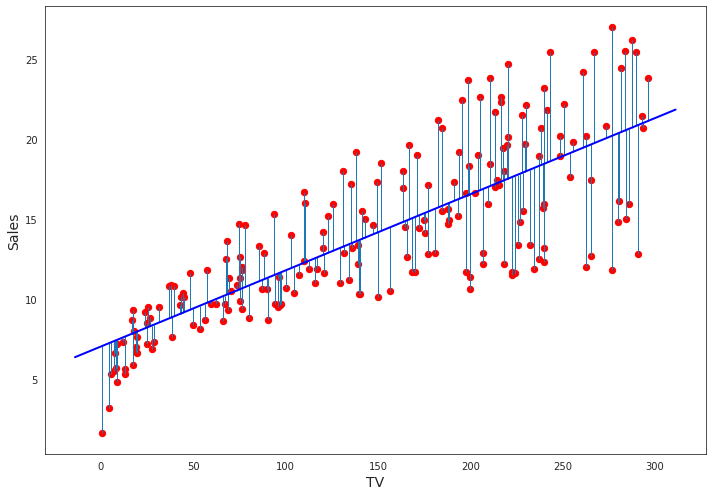

In [7]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.scatter(X, y, marker='o', color='red', s=40)
# plot the line for regression fit, gets the xy coordinates of the end points
x_1 = np.array(ax.get_xlim())
y_1 = constant + slope * x_1
ax.plot(x_1, y_1, color='blue', linewidth=2)

# let's also plot the error bars

lines = []
for i, x_ in enumerate(X): 
    origin = (X[i], constant + slope * X[i])
    end = (X[i], y[i])
    lines.append([origin, end])    
lc = mc.LineCollection(lines, linewidths=1)
ax.add_collection(lc)

ax.set_xlabel('TV', size=14)
ax.set_ylabel('Sales', size=14)
plt.tight_layout();

## 3. Gradient Descent
Another approach to find the optimal weights $\omega$ is to use iterative algorithms such as Gradient Descent. These methods are very important as in most of the cases it is not possible to find a closed form solution to $\omega$.


In [8]:
#append a column of ones to X, we do this to make sure that the dimensions of the matrices match
X = np.concatenate((np.ones(n).reshape(n,1), X.reshape(-1,1)), axis=1)

In [9]:
class gradient_decsent():
    def __init__(self, initial_w=0, gamma=0, max_epochs=50):
        self.initial_w = initial_w
        self.gamma = gamma
        self.max_epochs = max_epochs
    
    def calculate_loss(self, y, x, w):
        """
        calculate mse
        """
        e = y - x.dot(w)
        loss = 0.5*np.mean(e**2)
        return loss
    
    def calculate_gradient(self, y, x, w):
        """
        calculating the gradient of mse
        """
        e = y - x.dot(w)
        grad = -1 * x.T.dot(e) / len(e)
        return grad
    
    def update(self, y, x, w):
        """
        update step of GD
        """
        n, d = x.shape
        grad = self.calculate_gradient(y, x, w)
        w_new = w - self.gamma * grad
        return w_new
        
    def train(self, y, x):
        """
        training
        returns the vector of all loss values and weigths after training
        """
        n, d = x.shape
        w = self.initial_w
        ws = []
        losses = []
        for n_epoch in range(self.max_epochs):
            w = self.update(y, x, w)
            ws.append(w)
            losses.append(self.calculate_loss(y, x, w))
        return losses, ws


We would need to [standardize](https://towardsdatascience.com/normalization-vs-standardization-quantitative-analysis-a91e8a79cebf) the data before applying GD 

In [10]:
X[:,1] = X[:,1] - np.mean(X[:,1], axis=0)
X[:,1] = X[:,1] / np.std(X[:,1], axis=0)
#--
y = y - np.mean(y, axis=0)
y = y / np.std(y, axis=0)

In [11]:
GD = gradient_decsent(initial_w=np.array([0,0]), gamma=0.2, max_epochs=50)
losses, ws = GD.train(y, X)
print(ws[-1])

[-2.80997448e-16  7.82213261e-01]


In [12]:
def GD_vis(losses, ws, w0_range, w1_range, X, y, n_iter=None):
    w0, w1 = np.meshgrid(w0_range, w1_range)
    grid_losses = np.zeros((len(w0_range), len(w1_range)))
    for i in range(len(w0_range)):
        for j in range(len(w1_range)):
            w = np.array([w0[i,j], w1[i,j]])
            grid_losses[i,j] = GD.calculate_loss(y, X, w)
    fig = plt.figure(figsize=(10,7))

    # plot contourf
    ax1 = fig.add_subplot(1, 2, 1)
    cp = ax1.contourf(w0, w1, grid_losses, cmap=plt.cm.jet)
    fig.colorbar(cp, ax=ax1)
    ax1.set_xlabel(r'$w_0$')
    ax1.set_ylabel(r'$w_1$')
    # put a marker at the minimum
    ax1.plot(ws[-1][0], ws[-1][1], marker='*', color='r', markersize=20)

    # plot f(x)
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.scatter(X[:,1], y, marker=".", color='r', s=15)
    ax2.set_xlabel("x")
    ax2.set_ylabel("y")
    ax2.grid()
    ws_to_plot = np.stack(ws)
    if n_iter is not None:
        ws_to_plot = ws_to_plot[:n_iter]
    ax1.plot(
        ws_to_plot[:, 0], ws_to_plot[:, 1],
        marker='o', color='w', markersize=10)
    x_1 = np.array(ax2.get_xlim())
    y_1 = ws_to_plot[-1, 0] + ws_to_plot[-1, 1] * x_1
    ax2.plot(x_1, y_1, color='blue', linewidth=2);
    return fig

Let's see how it progresses through time

In [13]:
# Time Visualization
from ipywidgets import IntSlider, interact
def plot_figure(n_iter):
    fig = GD_vis(losses, ws, np.linspace(-1e-18, -4e-16, 100), np.linspace(0,1,100), X, y, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=50, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure>

## 4. Using Sklearn
When using sklearn we don't need to add a column of ones to the data in order to have the constant parameter. sklearn takes care of it, you should just pass the `fit_intercept` argument to be True (which is also the default value for this argument)

In [19]:
# Use the original data again
X = np.array(ad_df["TV"]).reshape((-1, 1))
y = np.array(ad_df["Sales"])

In [20]:
from sklearn.linear_model import LinearRegression
LR = LinearRegression(fit_intercept=True)
LR.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [21]:
print("slope: ", LR.coef_[0])
print("constant: ", LR.intercept_)
print("R^2 score: ", LR.score(X, y))

slope:  0.04753664043301975
constant:  7.032593549127695
R^2 score:  0.611875050850071


In [22]:
#predict the Sales of a product with 200 TV advertisments
LR.predict(np.array(200).reshape(-1, 1))

array([16.53992164])

In [23]:
# Alternative: mean squared error (MSE)
from sklearn.metrics import mean_squared_error
mean_squared_error(y, LR.predict(X))

10.512652915656757

## 5.Using more features for prediction
Let's try to use more features to predict the sales. For example we can observe the effect of TV and Radio advertisment in the same time.


In [24]:
#let's start with 2 features
#making the data matrix and outputs
X = np.array(ad_df[["TV", "Radio"]])
y = np.array(ad_df["Sales"])
X.shape, y.shape

((200, 2), (200,))

In [25]:
LR = LinearRegression(fit_intercept=True)
LR.fit(X, y)
print("params: ", LR.coef_)
print("constant: ", LR.intercept_)
print("R^2 score: ", LR.score(X, y))

params:  [0.04575482 0.18799423]
constant:  2.921099912405138
R^2 score:  0.8971942610828956


In [26]:
# predict
print("TV: ", 200, "Radio: ", 50, "Sales: ", LR.predict(np.array([200, 50]).reshape(-1,2)))
print("TV: ", 200, "Radio: ", 30, "Sales: ", LR.predict(np.array([200, 30]).reshape(-1,2)))

TV:  200 Radio:  50 Sales:  [21.47177426]
TV:  200 Radio:  30 Sales:  [17.71188973]


In [27]:
# with 3 features
X = np.array(ad_df[["TV", "Radio", "Newspaper"]])
y = np.array(ad_df["Sales"])
LR.fit(X, y)
print("params: ", LR.coef_)
print("constant: ", LR.intercept_)
print("R^2 score: ", LR.score(X, y))

params:  [ 0.04576465  0.18853002 -0.00103749]
constant:  2.938889369459412
R^2 score:  0.8972106381789521


In [28]:
# predict
print("TV: ", 200, "Radio: ", 50, "Newspaper: ", 50, "Sales: ", LR.predict(np.array([200, 50, 50]).reshape(-1,3)))
print("TV: ", 200, "Radio: ", 50, "Newspaper: ", 100, "Sales: ", LR.predict(np.array([200, 50, 100]).reshape(-1,3)))

TV:  200 Radio:  50 Newspaper:  50 Sales:  [21.46644465]
TV:  200 Radio:  50 Newspaper:  100 Sales:  [21.41457]


## 6.Using polynomial features (polynomial combination of features)
Sometimes the data cannot be explained by just a linear model and using a linear model causes a high error. In these cases we can add polynomial features to the data which is equivalent to fitting polynomial functions on the data points.

In [29]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2)
X = np.array(ad_df[["TV", "Radio"]])
y = np.array(ad_df["Sales"])
X_poly = poly.fit_transform(X)

In [30]:
X_poly.shape

(200, 6)

In [31]:
LR = LinearRegression(fit_intercept=False) # we don't need fit intercept sice polynomial features function add a column of ones to the data 
LR.fit(X_poly, y)
print("params: ", LR.coef_)
print("R^2 score: ", LR.score(X_poly, y))

params:  [ 5.19444187e+00  5.09930683e-02  2.65400299e-02 -1.09816273e-04
  1.07462080e-03  1.86076136e-04]
R^2 score:  0.986039101078374


Read about $R^2$ measure and you will be able to compare these models.

## 7.Train/Test split and overfitting

The standard practice in Machine Learning is to keep the test data out of the training and try to predict the output for the unseen data in the test set. We can also evaluate our model by calculating the MSE for training and test data.

Now let's see the effect of adding more polynomial features. Adding too much of these features may cause overfitting. We can check this by looking into the test error.

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [48]:
# let's again use 1 features
X = np.array(ad_df[["TV"]])
y = np.array(ad_df["Sales"])

Text(0, 0.5, 'error')

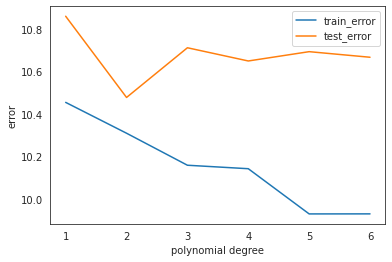

In [49]:
train_err = []
test_err = []
# X = X[:,0].reshape(-1,1)
for f in range(1,7):
    poly = PolynomialFeatures(f)
    X_poly = poly.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=1)
    LR = LinearRegression(fit_intercept=False)
    LR.fit(X_train, y_train)
    train_err.append(mean_squared_error(y_train, LR.predict(X_train)))
    test_err.append(mean_squared_error(y_test, LR.predict(X_test)))
plt.plot(range(1,7), train_err, label="train_error")
plt.plot(range(1,7), test_err, label="test_error")
plt.legend(fontsize=10)
plt.xlabel("polynomial degree")
plt.ylabel("error")
# plt.ylim([0, 100]);

To avoid overfitting we can penalize the norm of the weight vector. This is called regularization. We will use linear regression with l2 regularizer. By tuning the regularization parameter $\alpha$ we can minimize the test error.

In [70]:
from sklearn.linear_model import Ridge
poly = PolynomialFeatures(2)
X_poly = poly.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=1)
test_err = []
for alpha in np.linspace(0.1, 1, num=10):
    ridge_regression = Ridge(alpha=alpha)
    ridge_regression.fit(X_train, y_train)
    test_err.append(mean_squared_error(y_test, ridge_regression.predict(X_test)))
    

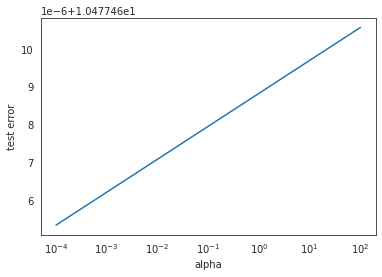

In [71]:
plt.semilogx(np.logspace(-4, 2, num=10), test_err)
plt.xlabel("alpha")
plt.ylabel("test error");

## 7.Cross validation
The standard way to do a hyperparameter tuning is through cross validation. We need to make sure that our model has a has a good generalisation power and performs well on unseen data. Therefore we have to keep 3 different sets of data: training set, validation set and test set.

In [72]:
# we use ridge regression with built in cross validation
# by default sklearn does leave-one-out cross validation
from sklearn.linear_model import RidgeCV
ridge = RidgeCV(fit_intercept=False, cv=5)
ridge.fit(X_train, y_train)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=5, fit_intercept=False,
        gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)

In [73]:
ridge.coef_

array([ 6.02967461e+00,  6.62911088e-02, -5.93557717e-05])

In [67]:
# best regularizer
ridge.alpha_

0.1

## Complementary material
### General closed form solution to linear regression:

In Linear regression we want to find the weights (parameters) that minimize the mean squared error which can be written in the form: $\frac{1}{n} (X\omega - y)^{\top}(X\omega -y)$, where $X, y, \omega$ are data matrix, outputs and weights respectively. By taking a derivative w.r.t $\omega$ we can find the closed form solution: $\omega = (X^{\top}X)^{-1}X^{\top}y$

In [75]:
#let's solve the equation to find w
A = X.T.dot(X)
B = X.T.dot(y)
#use numpy to solve a linear system of equations
w = np.linalg.solve(A, B)
print(w)

[0.08324961]


In [76]:
# compare the result with sklearn
LR = LinearRegression(fit_intercept=False)
LR.fit(X, y)
LR.coef_

array([0.08324961])